In [1]:
%cd ..

/home/tk/repos/explicit-memory


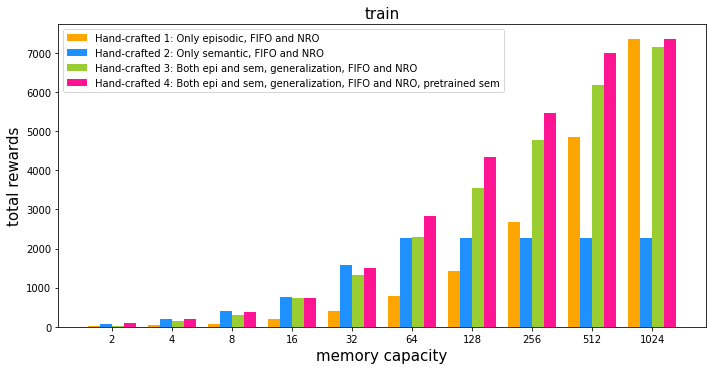

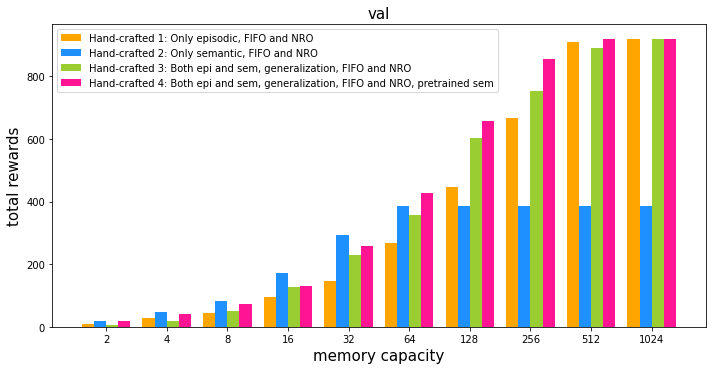

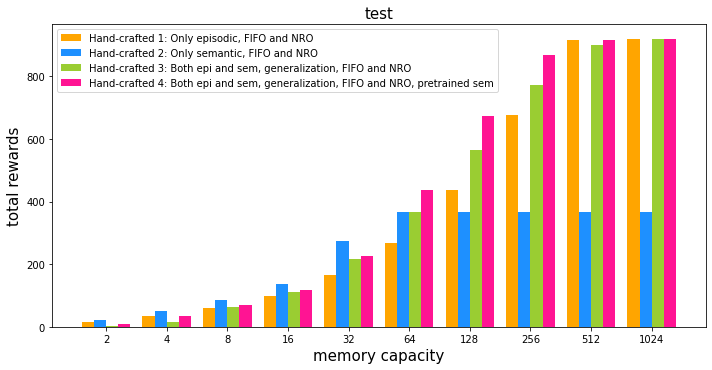

In [2]:
memory_order = ['episodic', 'semantic', 'both', 'both_presem']
color_order = ['orange', 'dodgerblue', 'yellowgreen', 'deeppink']
legend_order = ['Hand-crafted 1: Only episodic, FIFO and NRO', 
                'Hand-crafted 2: Only semantic, FIFO and NRO', 
                'Hand-crafted 3: Both epi and sem, generalization, FIFO and NRO',
                'Hand-crafted 4: Both epi and sem, generalization, FIFO and NRO, pretrained sem']

from utils import read_yaml
from glob import glob
import matplotlib.pyplot as plt
import numpy as np

results = [read_yaml(path) for path in glob('./training-results/*/results.yaml')]


results = {memory_type: [result for result in results if result['memory_type'] == memory_type] 
           for memory_type in memory_order}

for memory_type in memory_order:
    results[memory_type] = sorted(results[memory_type], key= lambda x:x['capacity']['episodic'] + x['capacity']['semantic'])
    
    
for split in ['train', 'val', 'test']:
    capacity = [sum(foo['capacity'].values()) for foo in results['episodic']]

    data = {memory_type: {cap: reward for cap, reward in zip(capacity, [foo[split]['rewards'] for foo in results[memory_type]])}
            for memory_type in memory_order}

    fig, ax = plt.subplots(figsize=(10,5))

    idx = np.asanyarray([i for i in range(len(capacity))])

    width = 0.2
    
    for memory_type, w, color in zip(memory_order, [-1.5,-0.5,0.5,1.5], color_order):
        ax.bar(idx+w*width, [val for key, val in sorted(data[memory_type].items())], width=width, color=color)

    ax.set_xticks(idx)
    ax.set_xticklabels(capacity)
    ax.legend(legend_order, fontsize=10)
    ax.set_xlabel('memory capacity', fontsize=15)
    ax.set_ylabel('total rewards', fontsize=15)

    fig.tight_layout()
    plt.title(split, fontsize=15)
    plt.savefig('./figures/' + split + '-bar.pdf',bbox_inches='tight')
    plt.show()